# Importation

---



Importer les données de Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = "/content/gdrive/My Drive/Gym_trainer/openpose/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Importer les différents modules python

In [2]:
import numpy as np

from itertools import product
from keras.callbacks import LearningRateScheduler
from keras.layers import  BatchNormalization, Convolution1D, Dense, Dropout, Flatten, MaxPooling1D, SpatialDropout1D, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from IPython.display import HTML
from math import floor, sqrt
from matplotlib import animation
from matplotlib import pyplot as plt
from pickle import load
from scipy import stats

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 18})

Using TensorFlow backend.


---

# Définitions des fonctions

---

## Traitement sur les données

Remplir les matrices avec des 0 pour qu'elles aient toutes la même taille

In [0]:
def pad_matrices(matrix_list):
  """Pad matrices with 0."""
  max_length = 0
  new_matrix_list = []
  for i in range(len(matrix_list)):
    shape = matrix_list[i].shape[1]
    if shape > max_length:
      max_length = shape
  for i in range(len(matrix_list)):
    shape = matrix_list[i].shape
    if shape[0] < max_length: # matrix_list[1].shape[0]
      pad_length = max_length - shape[1]
      pad = np.zeros((2, pad_length, shape[2]))
      new_matrix = np.append(matrix_list[i], pad, axis=1)
    else:
      new_matrix = matrix_list[i]
    new_matrix_list.append(new_matrix)
  new_matrix_list = np.array(new_matrix_list)
  return new_matrix_list

Découper les données entre ensemble de test et ensemble d'apprentissage

In [0]:
# def split_data(X, y, indice):
#   """Split data betwenn train set and test set."""
#   X_test = []
#   y_test = []
#   X_train = []
#   y_train = []
#   for i in range(len(y)):
#     if i < indice:
#       X_test.append(X[i])
#       y_test.append(y[i])
#     else:
#       X_train.append(X[i])
#       y_train.append(y[i])
#   X_test = np.array(X_test)
#   y_test = np.array(y_test)
#   X_train = np.array(X_train)
#   y_train = np.array(y_train)
#   return (X_test , y_test, X_train, y_train)

def split_data(X, y, indice):
  """Split data betwenn train set and test set."""
  X_test = []
  y_test = []
  X_train = []
  y_train = []
  for i in range(len(y)):
    if i in indice:
      X_test.append(X[i])
      y_test.append(y[i])
    else:
      X_train.append(X[i])
      y_train.append(y[i])
  X_test = np.array(X_test)
  y_test = np.array(y_test)
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  return (X_test , y_test, X_train, y_train)

Transformer les données

In [0]:
def transform_matrices(X):
  """Transform data."""
  shape = X.shape
  new_X = np.zeros((shape[0], shape[2], shape[1] * shape[3]))
  for i in range(shape[0]):
    for j in range(shape[2]):
      new_X[i, j ,:] = np.reshape(X[i, :, j, :], (1, shape[1] * shape[3]))
  return new_X

Supprimer les zéros lorsqu'une articulation n'est pas détectée

In [0]:
def delete_zeros(X):
  """Delete zeros in matrices and replace them with the previous value."""
  for i in range(len(X)):
    matrix = X[i]
    shape = matrix.shape
    for (j,k) in product(range(shape[1]), range(shape[2])):
      if matrix[0, j, k] == 0:
        matrix[:, j, k] = matrix[:, j - 1, k]
  X[i] = matrix
  return X

Normaliser les données

In [0]:
def standardize(X):
  """Standardize data according to a normal distribution."""
  for i in range(X.shape[2]):
    mu = np.mean(X[:, :, i])
    sigma = np.std(X[:, :, i])
    if sigma != 0:
      X[:, :, i] = (X[:, :, i] - mu) / sigma
  return X

## Modèle

Définir le modèle du CNN

In [0]:
def step_decay(epoch):
  initial_lrate = 0.001
  drop = 0.85
  epochs_drop = 10.0
  lrate = initial_lrate * pow(drop, floor((1 + epoch)/epochs_drop))
  return lrate

In [0]:
def define_model(dim1, dim2):
  """Define the model of the CNN with (dim1, dim2) as input shape."""
  shape = (dim1, dim2)
  model = Sequential()
  model.add(Convolution1D(16, 3, activation='relu', input_shape=shape))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  model.add(Convolution1D(32, 3, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  model.add(Convolution1D(64, 3, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  model.add(Convolution1D(128, 3, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  #model.add(Flatten())
  model.add(LSTM(128, activation='relu'))
  model.add(Dense(50,  activation='relu'))
  model.add(Dropout(0.8))
  model.add(Dense(1,  activation='linear'))
  model.summary()
  return model

## Affichage

Afficher l'historique du modèle

In [0]:
def print_history(history, name):
  """Summarize history by printing the loss of the model."""
  fig, ax = plt.subplots(figsize=(10,10))
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  ax.set(title='model loss (' + name + 'th person)', ylabel='loss', xlabel='epoch')
  ax.legend(['train', 'test'], loc='upper left')
  ax.grid(True, linestyle='-.')
  plt.show()

Afficher les résultats du modèle



In [0]:
def print_results(model, X_test, y_test, X_train, y_train):
  """Print the results of the model."""
  predict_test = model.predict(X_test)
  RMSE_test = np.linalg.norm(predict_test - y_test) / len(y_test)
  print("RMSE test", RMSE_test)
  predict_test = predict_test.flatten()
  corr = np.corrcoef(y_test, predict_test)
  print("corr test", corr[0,1])
  plt.plot(y_test, np.array(predict_test), '.r')
  plt.title('Predicted/real values on test set')
  plt.xlabel('real values')
  plt.ylabel('predicted values')
  plt.show()
  predict_train = model.predict(X_train)
  RMSE_train = np.linalg.norm(predict_train - y_train) / len(y_train)
  print("RMSE train", RMSE_train)
  predict_train = predict_train.flatten()
  corr = np.corrcoef(y_train, predict_train)
  print("corr test", corr[0,1])
  plt.plot(y_train, np.array(predict_train), '.r')
  plt.title('Predicted/real values on train set')
  plt.xlabel('real values')
  plt.ylabel('predicted values')
  plt.show()

Afficher les articulations dans une animation

In [0]:
def print_joints(X, video):
  "Plot an animation of the joints of the video at position 'video' in 'X'."
  fig, ax = plt.subplots(figsize=(10,10))
  joints, = ax.plot([], [], 'ro')
  left_arm, = ax.plot([], [], 'b-')
  right_arm, = ax.plot([], [], 'b-')
  tronc, = ax.plot([], [], 'b-')
  tronc2, = ax.plot([], [], 'b-')
  head, = ax.plot([], [], 'b-')
  ax.set(title='OpenPose keypoints', xlabel='x',
          ylabel='-y', ylim=(-1000,0), xlim=(350,1050))
  ax.grid(True, linestyle='-.')
  def init():
      joints.set_data([], [])
      left_arm.set_data([], [])
      right_arm.set_data([], [])
      tronc.set_data([], [])
      tronc2.set_data([], [])
      head.set_data([], [])
      return joints, left_arm, right_arm, tronc, tronc2, head,
  def animate(frame):
      joints.set_data(X[video][0,frame,:],-X[video][1,frame,:])
      left_arm.set_data(X[video][0,frame,1:5],-X[video][1,frame,1:5])
      ra = [1, 5, 6, 7]
      right_arm.set_data(X[video][0,frame,ra],-X[video][1,frame,ra])
      ra = [0, 1, 8, 9, 12, 13, 14, 19, 14, 20, 19, 21, 14]
      tronc.set_data(X[video][0,frame,ra],-X[video][1,frame,ra])
      ra = [9, 10, 11, 22, 11, 23, 22, 24, 11]
      tronc2.set_data(X[video][0,frame,ra],-X[video][1,frame,ra])
      ra = [1, 17, 0, 17, 15, 0, 15, 16, 0, 16, 18, 0, 18, 1]
      head.set_data(X[video][0,frame,ra],-X[video][1,frame,ra])
      return joints, left_arm, right_arm, tronc, tronc2, head,
  anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=X[video].shape[1], interval=150, blit=True)
  return HTML(anim.to_html5_video())

#print_joints(X,0)

---

# Programme

---

Charger les données

In [0]:
X = load(open(PATH + "Matrices.p", "rb"))
Personnes = np.load(PATH + 'Personnes.npy')
y = np.load(PATH + 'Notes.npy')

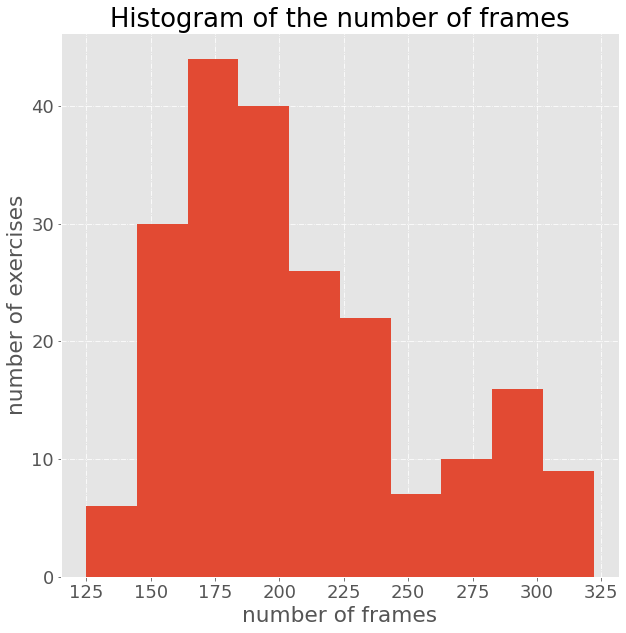

In [4]:
n_frames = [x.shape[1] for x in X]
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(n_frames, bins=10)
ax.set(title='Histogram of the number of frames', xlabel='number of frames', ylabel='number of exercises')
ax.grid(True, linestyle='-.')
plt.show()
fig.savefig(PATH + 'histogram' + '.eps', format='eps', dpi=1200)

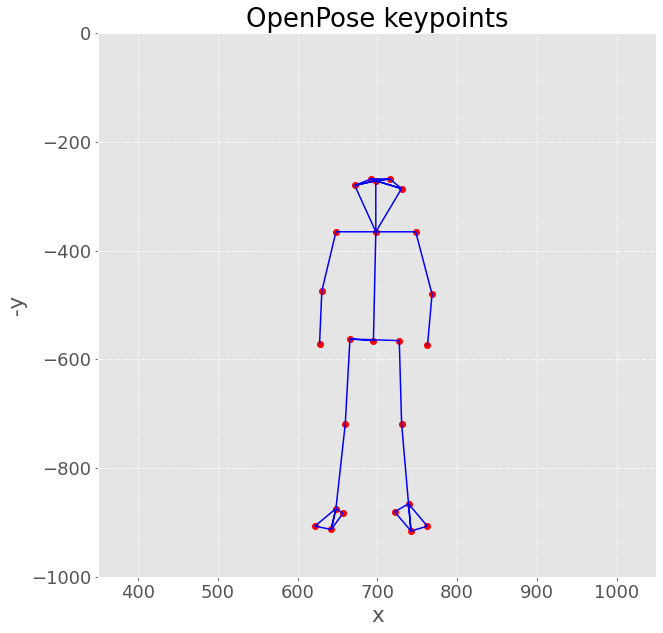

In [44]:
print_joints(X,31)

Réduire le nombre d'articulations

In [0]:
# for i in range(len(X)):
# 	X[i] = X[i][:,:,0:9] #8

Traiter les données

In [22]:
X = delete_zeros(X)

NameError: ignored

In [0]:
X = pad_matrices(X)
X = transform_matrices(X)
X = standardize(X)
y = y/45

Séparer les données

In [0]:
# indice = 40
# X_test , y_test, X_train, y_train = split_data(X,y, indice)

Créer le modèle

In [0]:
optimizer = Adam(lr=.001)
batch_size = 32
nb_epochs = 150
# lrate = LearningRateScheduler(step_decay)
model = define_model(X.shape[1], X.shape[2])
model.compile(loss='MSE', optimizer=optimizer)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 320, 16)           2416      
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 106, 16)           0         
_________________________________________________________________
spatial_dropout1d_45 (Spatia (None, 106, 16)           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 104, 32)           1568      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 34, 32)            0         
_________________________________________________________________
spatial_dropout1d_46 (Spatia (None, 34, 32)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 32, 64)          

Faire tourner le modèle tout d'un coup

In [0]:
# history = model.fit(X_train, y_train, epochs=nb_epochs, verbose=0,
#                    validation_data=(X_test, y_test), shuffle=True)
# print_history(history)
# print_results(model, X_test, y_test, X_train, y_train)

Faire tourner le modèle personne par personne

In [0]:
TEST_PRED = []
TEST_TRUE = []

for i in range(21):
	ind_test = np.where((Personnes == (i + 1)))
	ind_test = np.array(ind_test)
	X_test , y_test, X_train, y_train = split_data(X,y, ind_test)
	history = model.fit(X_train, y_train, epochs=nb_epochs, verbose=0,
	                    validation_data=(X_test, y_test), shuffle=True,
											batch_size=batch_size) # , callbacks=[lrate]
	print_history(history, str(ind_test[0][0]//10 +1))

	test = model.predict(X_test)
	TEST_PRED.append(test)
	TEST_TRUE.append(y_test)

TEST_TRUE = np.reshape(np.array(TEST_TRUE), 210)
TEST_PRED = np.reshape(np.array(TEST_PRED), 210)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(TEST_TRUE, TEST_PRED)
ax.plot(np.linspace(0,1),np.linspace(0,1), 'k:')
ax.set(title='Predicted/real values', xlabel='real mark',
         ylabel='predicted mark', xlim=(0,1.01), ylim=(0,1))
ax.grid(True, linestyle='-.')
slope, intercept, _, _, _ = stats.linregress(TEST_TRUE, TEST_PRED)
def linregr_predict(x):
   return slope * x + intercept
fitLine = linregr_predict(TEST_TRUE)
ax.plot(TEST_TRUE, fitLine, 'b-')
plt.show()
fig.savefig(PATH + 'new_cnn_lstm_4' + '.eps', format='eps', dpi=1200)

RMSE_test=np.linalg.norm(TEST_PRED-TEST_TRUE)/len(TEST_TRUE)
print("RMSE test", RMSE_test)
test = np.reshape(TEST_PRED,TEST_PRED.shape[0])
r = np.corrcoef(TEST_TRUE, TEST_PRED)
print("corr test",  r[0,1])

Récupérer les résultats du modèle

In [0]:
#print_results(model, X_test, y_test, X_train, y_train)

Sauvegarder le modèle

In [0]:
model.save(PATH + "new_cnn_lstm_4.h5")